### About
- This notebook has an implementations of the following papers.
    - [Depth Map Prediction from a Single Image using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf) by Eigen et al., NIPS 2014
    - CNN Residual + Fine (basically the network from the first papern but instead of Global coarse network -- CNN+Residual network)
- Dataset
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils
from skimage import transform
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import time
import os
import re
import random
from imageio import imread
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')

import torchvision.models as models

%matplotlib inline

In [ ]:
torch.cuda.is_available()

True

### Device configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyper parameters

In [ ]:
num_epochs = 10 # not specified in paper
bs = 32

### Dataset loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imagenet statistics
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# NYU dataset statistics
images_mean = [109.31410628 / 255, 109.31410628 / 255, 109.31410628 / 255]
images_std = [76.18328376 / 255, 76.18328376 / 255, 76.18328376 / 255]
#images_istd = 1.0 / images_std

depths_mean = [2.53434899]
depths_std = [1.22576694]
#depths_istd = 1.0 / depths_std

logdepths_mean = 0.82473954
logdepths_std = 0.45723134
logdepths_istd = 1.0 / logdepths_std

In [ ]:
data_dir_train = Path('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train')
data_dir_valid = Path('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/valid')

class DepthEigenDataset(Dataset):

    def __init__(self, rgb_dir, depth_dir, transform=None):
        super(DepthEigenDataset, self).__init__()
        
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.rgb_dir))
    
    def __getitem__(self, idx):
         
        # read as PIL images
        rgb_sample = Image.open(self.rgb_dir + '/{}.ppm'.format(idx))
        depth_sample = Image.open(self.depth_dir + '/{}.pgm'.format(idx))
        
        # transform
        seed = random.randint(0, 2 ** 32)
        if self.transform:
            random.seed(seed)
            rgb_sample = self.transform(rgb_sample)
            
            random.seed(seed)
            depth_sample = self.transform(depth_sample)
        
        # resize depth image
        depth_sample = transforms.Resize((74, 55))(depth_sample)
        
        # convert to torch tensor
        rgb_sample = transforms.ToTensor()(rgb_sample)
        rgb_sample =  transforms.Normalize(images_mean, images_std)(rgb_sample)
        depth_sample = transforms.ToTensor()(depth_sample).view(74, 55)
        
        # normalize
        #rgb_sample =  transforms.Normalize(images_mean, images_std)(rgb_sample)
        #depth_sample = transforms.Normalize(depths_mean, depths_std)(depth_sample).view(74, 55)
        
        sample = {'rgb':rgb_sample, 'depth': depth_sample}
        
        return sample

trans_train = transforms.Compose([
    transforms.Resize((320, 240)),
    transforms.RandomRotation(5),
    transforms.RandomCrop((304, 228)),
    transforms.RandomHorizontalFlip(),
])

trans_test = transforms.Compose([
    transforms.Resize((304, 228)),
])
    
dataset_train = DepthEigenDataset(str(data_dir_train)+'/rgb', str(data_dir_train) + '/depth', transform=trans_train)
dataloader_train = DataLoader(dataset_train, batch_size=bs, shuffle=True)

dataset_valid = DepthEigenDataset(str(data_dir_valid) + '/rgb', str(data_dir_valid) + '/depth', transform=trans_test)
dataloader_valid = DataLoader(dataset_valid, batch_size=bs, shuffle=True)

datalen_train = len(dataset_train)
datalen_valid = len(dataset_valid)

print(datalen_train, datalen_valid)

400 2753


### Network definition

In [ ]:
class GlobalCoarseNet(nn.Module):
    
    def __init__(self, init=True):
        super(GlobalCoarseNet, self).__init__()
        
        self.coarse1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
                                     #nn.BatchNorm2d(96),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        
        self.coarse2 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
                                     #nn.BatchNorm2d(256),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        
        self.coarse3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
                                     #nn.BatchNorm2d(384),
                                     nn.ReLU())
        
        self.coarse4 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), 
                                     #nn.BatchNorm2d(384),
                                     nn.ReLU())
        
        self.coarse5 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=2), 
                                     #nn.BatchNorm2d(256),
                                     nn.ReLU())
        
        self.coarse6 = nn.Sequential(nn.Linear(in_features=256 * 8 * 6, out_features=4096), 
                                     nn.ReLU(), nn.Dropout(0.5))
        
        self.coarse7 = nn.Sequential(nn.Linear(in_features=4096, out_features=74 * 55))
        
        if init:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    m.bias.data.fill_(0)
                elif isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight)
                    m.bias.data.fill_(0)

    def forward(self, x):
        x = self.coarse1(x)
        x = self.coarse2(x)
        x = self.coarse3(x)
        x = self.coarse4(x)
        x = self.coarse5(x)
        x = x.reshape(x.size(0), -1)
        x = self.coarse6(x)
        x = self.coarse7(x)
        x = x.reshape(x.size(0), 74, 55)
        return x

class LocalFineNet(nn.Module):
    
    def __init__(self, init=True):
        super(LocalFineNet, self).__init__()
        
        self.fine1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=63, kernel_size=9, stride=2),
                                   nn.BatchNorm2d(63),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        
        self.fine2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2), 
                                   #nn.BatchNorm2d(64),
                                   nn.ReLU())
        
        self.fine3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
        
        if init:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    m.bias.data.fill_(0)
                elif isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight)
                    m.bias.data.fill_(0)

    def forward(self, x, global_output_batch):
        x = self.fine1(x)
        x = torch.cat((x, global_output_batch), dim=1)
        x = self.fine2(x)
        x = self.fine3(x)
        
        return x

# initialize
global_model = GlobalCoarseNet(init=False).to(device)
local_model = LocalFineNet(init=False).to(device)

### CNN + Residual

In [ ]:
class upmodel(nn.Module):
  def __init__(self,inp_dim):
    super(upmodel,self).__init__()
    self.inp_dim = inp_dim
    self.unpool = nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.conv1 = nn.Conv2d(in_channels=inp_dim[0],out_channels=int(inp_dim[0]/2),kernel_size=5,stride=1,padding=2)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=int(inp_dim[0]/2),out_channels=int(inp_dim[0]/4),kernel_size=3,stride=1,padding=1)
    self.conv_side = nn.Conv2d(in_channels=int(inp_dim[0]),out_channels=int(inp_dim[0]/4),kernel_size=5,stride=1,padding=2)
  def forward(self,inp):
    x = torch.zeros(inp.shape[0],inp.shape[1],2*inp.shape[2],2*inp.shape[3]).float()
    x[:,:,::2,::2] = inp
    #print(x)
    # Without using maxUnpool3d
    x1 = self.conv1(x)
    x1 = self.relu(x1)
    x1 = self.conv2(x1)
    x2 = self.conv_side(x)
    return torch.cat((x1,x2),dim = 1)

In [ ]:
def weights_init(m):
    if type(m) in [nn.Linear]:
        print("setting custom wts")
        #m.weight.data.register_hook(lambda grad: print(grad))
        m.weight.data = torch.randn(m.weight.data.shape).float() * math.sqrt(2/m.weight.data.shape[1])
        m.bias.data = torch.randn(m.bias.data.shape).float() * math.sqrt(2/m.weight.data.shape[1])
        #print(m.weight.data, m.bias.data)
    elif type(m) in [nn.Conv2d]:
        print("setting custom wts")
        #m.weight.data.register_hook(lambda grad: print(grad))
        m.weight.data = torch.randn(m.weight.data.shape).float() * math.sqrt(2/(m.weight.data.shape[1]*m.weight.data.shape[2]*m.weight.data.shape[3]))
        m.bias.data = torch.randn(m.bias.data.shape).float() * math.sqrt(2/(m.weight.data.shape[1]*m.weight.data.shape[2]*m.weight.data.shape[3]))
        #print(m.weight.data, m.bias.data)

In [ ]:
import torchvision.models as models
import math

# CNN Residual
class fullmodel(nn.Module):
  def __init__(self):
    super(fullmodel,self).__init__()
    self.res = models.resnet50(pretrained=True)
    self.res = nn.Sequential(*(list(self.res.children())[:-2]))
    for param in self.res.parameters():
      param.requires_grad = False
    self.first_conv = nn.Conv2d(in_channels=2048,out_channels=1024,kernel_size=1,stride=1,padding=0)
    self.batchNorm = nn.BatchNorm2d(1024)
    self.upsample1 = upmodel([1024,7,9]) #upprojection/upsampling
    self.upsample2 = upmodel([512,14,18])
    self.upsample3 = upmodel([256,28,36])

    self.convlayer0 = nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=2,stride=1,padding=0)
    self.convlayer01 = nn.Conv2d(in_channels=512,out_channels=256,kernel_size=2,stride=1,padding=0)

    self.convlayer02 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
                                     #nn.BatchNorm2d(384),
                                     nn.ReLU())
        
    self.convlayer03 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), 
                                  #nn.BatchNorm2d(384),
                                  nn.ReLU())
    
    self.convlayer04 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=2), 
                                  #nn.BatchNorm2d(256),
                                  nn.ReLU())
    
    self.convlayer05 = nn.Sequential(nn.Linear(in_features=1536, out_features=4096), 
                                  nn.ReLU(), nn.Dropout(0.5))
    
    self.convlayer06 = nn.Sequential(nn.Linear(in_features=4096, out_features=74 * 55))

    self.convlayer = nn.Conv2d(in_channels=128,out_channels=1,kernel_size=3,stride=1,padding=0)
    self.convlayer2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
    self.coarse6 = nn.Sequential(nn.Linear(in_features=128, out_features=4096), 
                                     nn.ReLU(), nn.Dropout(0.5))
        
    self.coarse7 = nn.Sequential(nn.Linear(in_features=4096, out_features=74 * 55))
    self.relu = nn.ReLU()
    #self.init_weights()
    
  def init_weights(self) :
    self.upsample1.apply(weights_init)
    self.upsample2.apply(weights_init)
    self.upsample3.apply(weights_init)
    self.first_conv.apply(weights_init)
    self.convlayer.apply(weights_init)
  def forward(self,inp):
    #print('here forward')
    x = self.res(inp)
    #print('here res')
    x = self.first_conv(x)
    #print('here conv')
    x = self.batchNorm(x)
    #x = self.upsample1(x)
    #x = self.upsample2(x)
    #print('x after upsample2:', x.shape)
    #x = self.upsample3(x)
    #print('x after upsample3:', x.shape)

    x = self.convlayer0(x)
    x = self.convlayer01(x)
    x = self.convlayer02(x)
    x = self.convlayer03(x)
    x = self.convlayer04(x)
    #print("1", x.shape)
    x = x.reshape(x.size(0), -1)
    #print("2", x.shape)
    x = self.convlayer05(x)
    x = self.convlayer06(x)
    #print('x after convlayers:', x.shape)        

    #x = self.convlayer(x)
    #print('x after convlayer:', x.shape)
    #x = x.reshape(x.size(0), -1)
    #x = self.coarse6(x)
    #x = self.coarse7(x)
    x = x.reshape(x.size(0), 74, 55)
    x = self.relu(x)
    #print(x.shape)
    '''
    x = x[:,:,:-1,:]
    x1 = torch.zeros(x.shape[0],x.shape[2],x.shape[3])
    print('x1', x1.shape)
    for i in range(x.shape[0]):
      x1[i] = x[i,0,:,:]'''
    return x

full_model = fullmodel().to(device)

### Loss and optimizer
- Reference
    - [Per-parameter options](https://pytorch.org/docs/stable/optim.html)

In [ ]:
class ScaleInvariantLoss(nn.Module):
    def __init__(self):
        super(ScaleInvariantLoss, self).__init__()

    def forward(self, pred, target):
        
        # mask out zero values and invalid regions
        mask = (target == 0) | (target == target.max()) | (target == target.min())
        dist = pred[~mask] - torch.log(target[~mask])
        
        # the lambda parameter is set to 0.5
        loss = torch.mean(dist ** 2) - 0.5 / ((torch.numel(dist)) ** 2) * (torch.sum(dist) ** 2) 
        
        return loss

# loss
global_criterion = ScaleInvariantLoss()
local_criterion = ScaleInvariantLoss()

# optimizer
r = 0.1
global_optimizer = torch.optim.SGD([{'params': global_model.coarse6.parameters(), 'lr': 0.1*r},
                                    {'params': global_model.coarse7.parameters(), 'lr': 0.1*r}], 
                                   lr=0.001*r, momentum=0.9, weight_decay=0.1)

local_optimizer = torch.optim.SGD([{'params': local_model.fine2.parameters(), 'lr': 0.01*r}], 
                                  lr=0.001*r, momentum=0.9, weight_decay=0.1)

# data parallel
global_model = nn.DataParallel(global_model)
local_model = nn.DataParallel(local_model)

### Plot gradient flow and losses
- Reference
    - [plot function](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7)
    - [get gradient of each layer](https://discuss.pytorch.org/t/how-to-calculate-gradient-for-each-layer/1595/4)

In [ ]:
def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='validation')
    
    plt.xlabel("Iterations")
    plt.ylabel("Losses")
    
    plt.legend()
    plt.title("Losses")
    plt.grid(True)

def plot_losses_comparison(train_losses, valid_losses):
    plt.plot(train_losses, label='Course-Fine networks')
    plt.plot(valid_losses, label='CNN Residual-Fine networks')
    
    plt.xlabel("Iterations")
    plt.ylabel("Losses")
    
    plt.legend()
    plt.title("Losses")
    plt.grid(True)

### Train the global coarse model (from Coarse-Fine network)

> > > > > > > > > > Time used:  2846.391058444977  per epoch used:  284.6391058444977


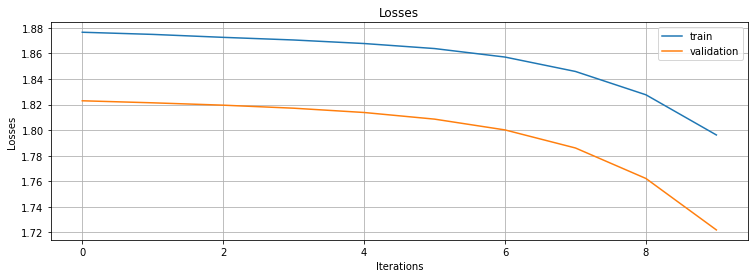

In [ ]:
figsize(12.5, 4)

train_losses = []
valid_losses = []
tl_b = []

start = time.time()
#for epoch in range(num_epochs):
for epoch in range(10):    
    print('>', end=' ')
    
    # train
    train_loss = 0
    global_model.train()
    for i, samples in enumerate(dataloader_train):
        
        rgbs = samples['rgb'].float().to(device)
        depths = samples['depth'].float().to(device)
        
        # forward pass
        output = global_model(rgbs)
        loss = global_criterion(output, depths)

        # backward pass
        global_model.zero_grad()
        loss.backward()

        # optimization
        global_optimizer.step()
        
        train_loss += loss.item()
        tl_b.append(loss.item())
        
    train_losses.append(train_loss / datalen_train)
    
    # validation
    valid_loss = 0
    global_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):
        
            rgbs = samples['rgb'].float().to(device)
            depths = samples['depth'].float().to(device)

            # forward pass
            output = global_model(rgbs)
            loss = global_criterion(output, depths)
            
            valid_loss += loss.item()
            
    valid_losses.append(valid_loss / datalen_valid)
    
    # save model
    torch.save(global_model, '/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/global_model.pt')
    
elapse = time.time() - start 
print('Time used: ', elapse, ' per epoch used: ', elapse / num_epochs)
plot_losses(train_losses, valid_losses)

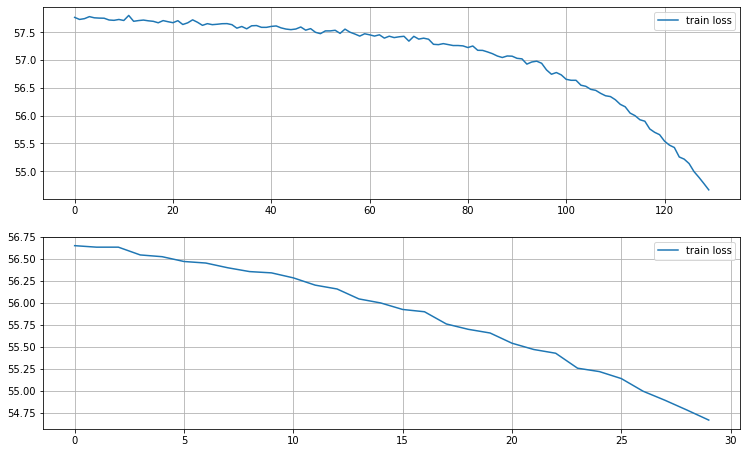

In [ ]:
figsize(12.5, 12)

plt.subplot(311)
plt.plot(tl_b, label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(tl_b[100:], label='train loss')
plt.grid(True)
plt.legend()
'''
plt.subplot(313)
plt.plot(tl_b[300:], label='train loss')
fml = np.mean(tl_b[-320:])
plt.axhline(y = fml, color='r', linestyle='-', label='final mean train loss: {:.2f}'.format(fml))
plt.grid(True)
plt.legend()'''

### Train the local fine model ((from Coarse-Fine network)

> > > > > Time used:  296.95566868782043  per epoch used:  29.695566868782045


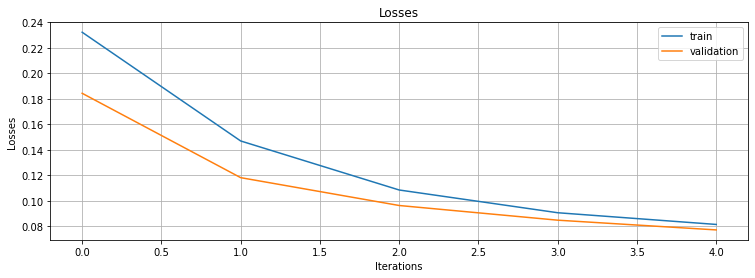

In [ ]:
figsize(12.5, 4)

train_losses_old, valid_losses_old = [], []
tl_b_ = []
start = time.time()
for epoch in range(5):
    
    print('>', end=' ')
    
    # train
    train_loss = 0
    local_model.train()
    for i, samples in enumerate(dataloader_train):
        
        rgbs = samples['rgb'].float().to(device)
        depths = samples['depth'].float().to(device)
        
        # results from global coarse network
        global_model.eval()
        with torch.no_grad():
            global_output = global_model(rgbs).unsqueeze(1)
            #global_output = global_output * depths_std[0] + depths_mean[0]

        # forward pass
        output = local_model(rgbs, global_output).squeeze(1)
        loss = local_criterion(output, depths)

        # backward pass
        local_model.zero_grad()
        loss.backward()

        # optimization
        local_optimizer.step()
        
        train_loss += loss.item()
        tl_b_.append(loss.item())
        
    train_losses_old.append(train_loss / datalen_train)

    # valid
    valid_loss = 0
    local_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):

            rgbs = samples['rgb'].float().to(device)
            depths = samples['depth'].float().to(device)

            # results from global coarse network
            global_model.eval()
            with torch.no_grad():
                global_output = global_model(rgbs).unsqueeze(1)

            # forward pass
            output = local_model(rgbs, global_output).squeeze(1)
            loss = local_criterion(output, depths)
            
            valid_loss += loss.item()
    valid_losses_old.append(valid_loss / datalen_valid)
    
    # save model
    torch.save(local_model, '/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/local_model.pt')

elapse = time.time() - start 
print('Time used: ', elapse, ' per epoch used: ', elapse / num_epochs)
plot_losses(train_losses_old, valid_losses_old)

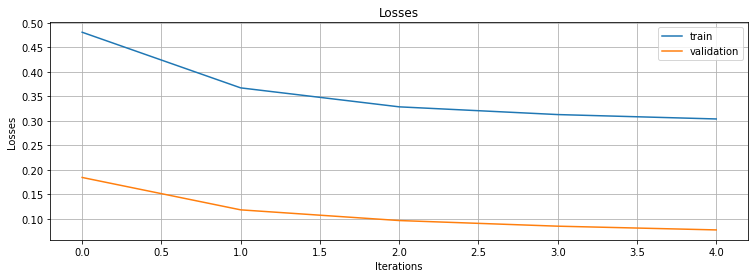

In [ ]:
plot_losses(valid_losses_[:-5], valid_losses_old)

"\nplt.subplot(313)\nplt.plot(tl_b_[300:], label='train loss')\nfml = np.mean(tl_b_[-320:])\nplt.axhline(y = fml, color='r', linestyle='-', label='final mean train loss: {:.2f}'.format(fml))\nplt.grid(True)\nplt.legend()"

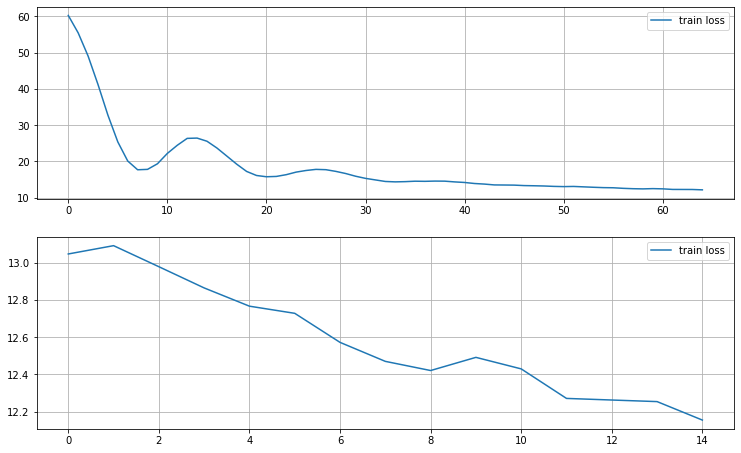

In [ ]:
figsize(12.5, 12)

plt.subplot(311)
plt.plot(tl_b_, label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(tl_b_[50:], label='train loss')
plt.grid(True)
plt.legend()
'''
plt.subplot(313)
plt.plot(tl_b_[300:], label='train loss')
fml = np.mean(tl_b_[-320:])
plt.axhline(y = fml, color='r', linestyle='-', label='final mean train loss: {:.2f}'.format(fml))
plt.grid(True)
plt.legend()'''

### Train Full model (CNN+Residual+Fine model)

> > > > > > > > > > Time used:  917.9209506511688  per epoch used:  91.79209506511688


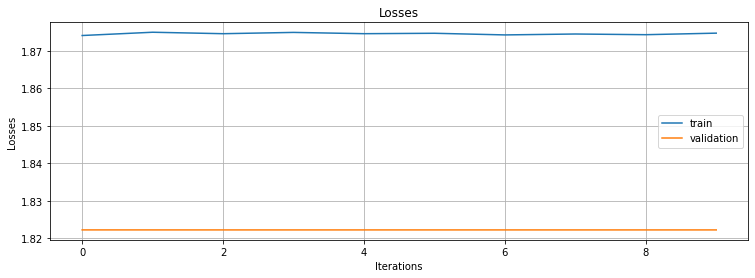

In [ ]:
figsize(12.5, 4)

train_losses = []
valid_losses = []
tl_b = []

start = time.time()
#for epoch in range(num_epochs):
for epoch in range(10):    
    print('>', end=' ')
    
    # train
    train_loss = 0
    full_model.train()
    for i, samples in enumerate(dataloader_train):
        
        rgbs = samples['rgb'].float().to(device)
        depths = samples['depth'].float().to(device)
        
        # forward pass
        output = full_model(rgbs)
        loss = global_criterion(output, depths)

        # backward pass
        full_model.zero_grad()
        loss.backward()

        # optimization
        global_optimizer.step()
        
        train_loss += loss.item()
        tl_b.append(loss.item())
        
    train_losses.append(train_loss / datalen_train)
    
    # validation
    valid_loss = 0
    full_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):
        
            rgbs = samples['rgb'].float().to(device)
            depths = samples['depth'].float().to(device)

            # forward pass
            output = full_model(rgbs)
            loss = global_criterion(output, depths)
            
            valid_loss += loss.item()
            
    valid_losses.append(valid_loss / datalen_valid)
    
    # save model
    torch.save(full_model, '/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/full_model.pt')
    
elapse = time.time() - start 
print('Time used: ', elapse, ' per epoch used: ', elapse / num_epochs)
plot_losses(train_losses, valid_losses)

> > > > > > > > > > Time used:  889.189436674118  per epoch used:  88.91894366741181


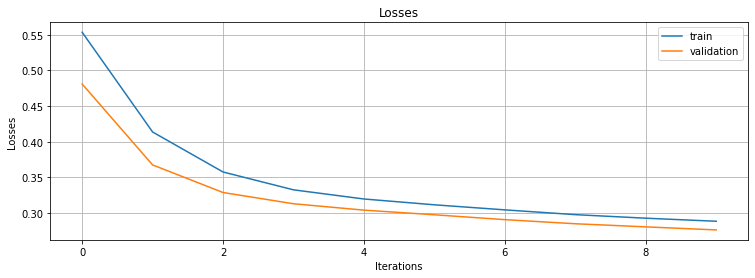

In [ ]:
figsize(12.5, 4)

train_losses_, valid_losses_ = [], []
tl_b_ = []
start = time.time()
for epoch in range(10):
    
    print('>', end=' ')
    
    # train
    train_loss = 0
    local_model.train()
    for i, samples in enumerate(dataloader_train):
        
        rgbs = samples['rgb'].float().to(device)
        depths = samples['depth'].float().to(device)
        
        # results from global coarse network
        full_model.eval()
        with torch.no_grad():
            global_output = full_model(rgbs).unsqueeze(1)
            #global_output = global_output * depths_std[0] + depths_mean[0]

        # forward pass
        output = local_model(rgbs, global_output).squeeze(1)
        loss = local_criterion(output, depths)

        # backward pass
        local_model.zero_grad()
        loss.backward()

        # optimization
        local_optimizer.step()
        
        train_loss += loss.item()
        tl_b_.append(loss.item())
        
    train_losses_.append(train_loss / datalen_train)

    # valid
    valid_loss = 0
    local_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):

            rgbs = samples['rgb'].float().to(device)
            depths = samples['depth'].float().to(device)

            # results from global coarse network
            full_model.eval()
            with torch.no_grad():
                global_output = full_model(rgbs).unsqueeze(1)

            # forward pass
            output = local_model(rgbs, global_output).squeeze(1)
            loss = local_criterion(output, depths)
            
            valid_loss += loss.item()
    valid_losses_.append(valid_loss / datalen_valid)
    
    # save model
    torch.save(local_model, '/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/local_for_full_model.pt')

elapse = time.time() - start 
print('Time used: ', elapse, ' per epoch used: ', elapse / num_epochs)
plot_losses(train_losses_, valid_losses_)

### Comparison

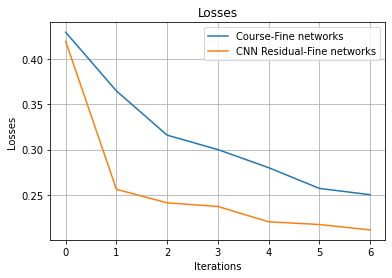

In [ ]:
plot_losses_comparison(train_losses_old, train_losses_)

### Validation

In [ ]:
for i, samples in enumerate(dataloader_valid):

    rgbs = samples['rgb'].float().to(device)
    depths = samples['depth'].float().to(device)

    # results from global coarse network
    global_model.eval()
    with torch.no_grad():
        global_output = global_model(rgbs).unsqueeze(1)
        #global_output_ = global_output * depths_std[0] + depths_mean[0]
    
    # results from local fine network
    local_model.eval()
    with torch.no_grad():
        local_output = local_model(rgbs, global_output)
        #local_output = local_output * depths_std[0] + depths_mean[0]
    
    break

In [ ]:
from PIL import Image as ImagePIL
import matplotlib.image as mpimg

img = ImagePIL.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/rgb/155.ppm')
img.save("image.jpg")

image = mpimg.imread("image.jpg")

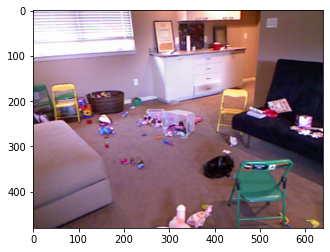

In [ ]:
img1 = ImagePIL.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/valid/rgb/700.ppm')
img1.save("image11temp.jpg")

image1 = mpimg.imread("image11temp.jpg")
plt.imshow(image1)

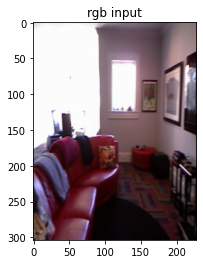

In [ ]:
figsize(15, 4)
plt.title('rgb input')
image = transform.resize(image, (304,  228))
plt.imshow(image)

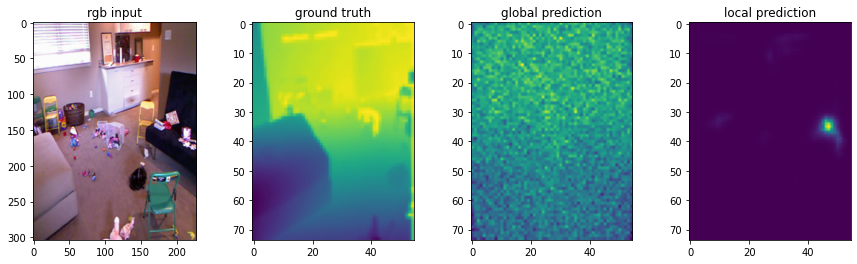

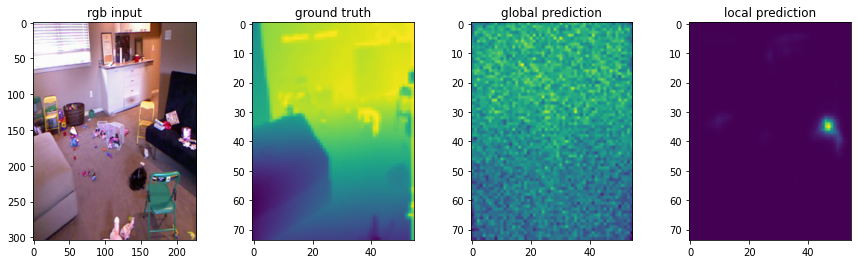

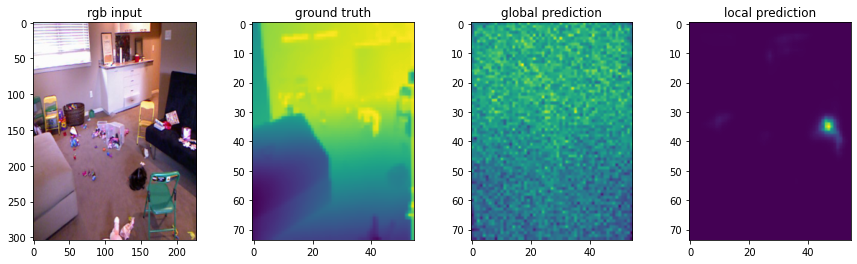

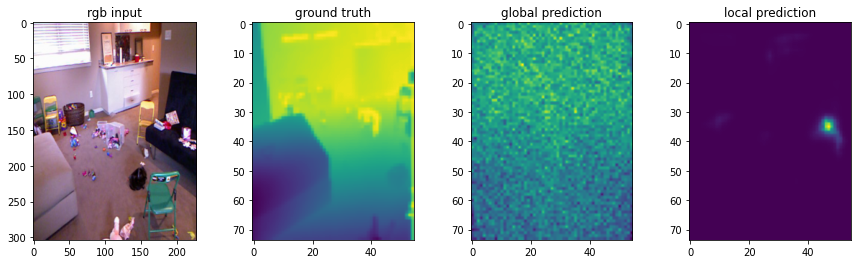

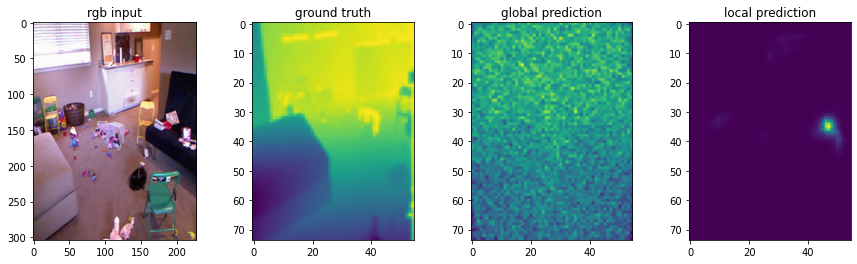

In [ ]:
figsize(15, 4)

for i in range(5):

    dg = global_output[i].view(74, 55)
    dg = torch.exp(dg)
    dl = local_output[i].view(74, 55)
    dl = torch.exp(dl)
    
    #r = transforms.Normalize(mean=[], std=[])(rgbs[i])
    #r = rgbs[i] * 76 + 109
    #r = np.array(r)
    #r = rgbs[i]
    
    r = transforms.ToPILImage()(rgbs[i].cpu())
    
    image = transform.resize(image, (304,  228))

    d_true = depths[i]
    
    plt.subplot(141)
    plt.title('rgb input')
    plt.imshow(image)
    
    plt.subplot(142)
    plt.title('ground truth')
    plt.imshow(d_true.cpu())
    
    plt.subplot(143)
    plt.title('global prediction')
    plt.imshow(dg.cpu())
    
    plt.subplot(144)
    plt.title('local prediction')
    plt.imshow(dl.cpu())

    plt.show()

In [ ]:
image_tr = transform.resize(image, (74,  55))

### 3D reconstruction

In [ ]:
import cv2
#im = ImagePIL.open("image.jpg")
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
        
        
#generating 3d point cloud
disp = np.float32(dl.cpu())
im_f = np.float32(image_tr)
print('generating 3d point cloud...',)
h, w = im_f.shape[:2]
f = 0.2*w                   # guess for focal length

#disparity-to-depth mapping matrix
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(disp, Q)
colors = cv2.cvtColor(im_f, cv2.COLOR_BGR2RGB)
mask = disp > disp.mean() #с маской все работает в MeshLab, без маски - не открывает из-за наличия нулевых столбцов
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out5.ply'
write_ply('out5.ply', out_points, out_colors)
print('%s saved' % 'out5.ply')

generating 3d point cloud...
out5.ply saved
